In [1]:
import random

import torch
import torch.nn as nn
import torch.backends
from torch import optim
from torch.hub import load_state_dict_from_url
from torch.nn import CrossEntropyLoss
from torchvision import datasets
from torchvision import models
from torchvision.transforms import transforms
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from baal.active import get_heuristic, ActiveLearningDataset
from baal.active.active_loop import ActiveLearningLoop
from baal.bayesian.dropout import patch_module
from baal.modelwrapper import ModelWrapper
from dataclasses import dataclass
import numpy as np
from copy import deepcopy
from collections import defaultdict

def vgg16(num_classes):
    model = models.vgg16(pretrained=False, num_classes=num_classes)
    weights = load_state_dict_from_url('https://download.pytorch.org/models/vgg16-397923af.pth')
    weights = {k: v for k, v in weights.items() if 'classifier.6' not in k}
    model.load_state_dict(weights, strict=False)
    return model

In [2]:
# We will make an adapter so that `pool_specifics` modifies the transform correctly.
import torch.utils.data as torchdata


class TransformAdapter(torchdata.Subset):

    @property
    def transform(self):
        if hasattr(self.dataset, 'transform'):
            return self.dataset.transform
        else:
            raise AttributeError()

    @transform.setter
    def transform(self, transform):
        if hasattr(self.dataset, 'transform'):
            self.dataset.transform = transform

In [3]:
@dataclass
class ExperimentConfig:
    epoch: int = 20000//256
    batch_size: int = 32
    initial_pool: int = 512
    query_size: int = 256
    lr: float = 0.001
    heuristic: str = 'bald'
    iterations: int = 40
    training_duration: int = 40
        

def get_datasets(initial_pool):
    transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(30),
         transforms.ToTensor(),
         transforms.Normalize(3 * [0.5], 3 * [0.5]), ])
    test_transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(3 * [0.5], 3 * [0.5]),
        ]
    )
    
    train_ds = datasets.CIFAR100('.', train=True,
                                transform=transform, target_transform=None, download=True)
    validation_ds = datasets.CIFAR100('.', train=True,
                                transform=test_transform, target_transform=None, download=True)
    test_set = datasets.CIFAR100('.', train=False,
                                transform=test_transform, target_transform=None, download=True)
    
    # we split train set in two to get a validation set
    train_idx, val_idx = train_test_split(np.arange(len(train_ds)), test_size=0.2)
    train_ds = TransformAdapter(train_ds, train_idx)
    validation_ds = torchdata.Subset(validation_ds, val_idx)
    
    # Here we set `pool_specifics`, where we set the transform attribute for the pool.
    active_set = ActiveLearningDataset(train_ds, pool_specifics={'transform': test_transform})

    # We start labeling randomly.
    active_set.label_randomly(initial_pool)
    return active_set, validation_ds, test_set


In [4]:
hyperparams = ExperimentConfig()
use_cuda = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True
random.seed(1337)
torch.manual_seed(1337)
if not use_cuda:
    print("warning, the experiments would take ages to run on cpu")

# Get datasets
active_set, val_set, test_set = get_datasets(hyperparams.initial_pool)

heuristic = get_heuristic(hyperparams.heuristic)
criterion = CrossEntropyLoss()
model = vgg16(num_classes=100)

# change dropout layer to MCDropout
model = patch_module(model)

if use_cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=hyperparams.lr, momentum=0.9)

# Wraps the model into a usable API.
model = ModelWrapper(model, criterion)

# for prediction we use a smaller batchsize
# since it is slower
active_loop = ActiveLearningLoop(active_set,
                                 model.predict_on_dataset,
                                 heuristic,
                                 hyperparams.query_size,
                                 batch_size=1,
                                 iterations=hyperparams.iterations,
                                 use_cuda=use_cuda)

# We will reset the weights at each active learning step.
init_weights = deepcopy(model.state_dict())

def nuke_last(model):
    last = ['classifier.3', 'classifier.6']
    last = ['classifier.6']
    for name, m in model.model.named_modules():
        if 'classifier' not in name:
            continue
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
reports = defaultdict(list)
cfg_no_es = {'epoch': 10, 'patience': None}
cfg_es = {'epoch': 40, 'patience': 5}

for name,cfg in [('No ES', cfg_no_es), ('ES', cfg_es)]: 
    active_set.reset_labeled()
    active_set.label_randomly(hyperparams.initial_pool)
    for epoch in tqdm(range(hyperparams.epoch)):
        if cfg['patience'] is not None:
            nuke_last(model)
        else:
            # Load the initial weights.
            model.load_state_dict(init_weights)

        _, weight = model.train_and_test_on_datasets(active_set, val_set,
                                        optimizer=optimizer, batch_size=hyperparams.batch_size,
                                                     use_cuda=use_cuda, return_best_weights=True, **cfg
                                        )

        if cfg['patience'] is not None:
            model.load_state_dict(weight)
        # Get test NLL!
        model.test_on_dataset(test_set, 1, use_cuda,
                              average_predictions=hyperparams.iterations)
        metrics = model.metrics

        # We can now label the most uncertain samples according to our heuristic.
        should_continue = active_loop.step()
        if not should_continue:
                break

        test_loss = metrics['test_loss'].value
        logs = {
            "test_nll": test_loss,
            "epoch": epoch,
            "Next Training set size": len(active_set)
        }
        reports[name].append(logs)
        print(logs)
        if len(active_set) >= 40000:
            break

[61716-MainThread] [baal.modelwrapper:train_on_dataset:109] 2021-02-11T01:58:18.524712Z [info     ] Starting training              dataset=512 epoch=1
[61716-MainThread] [baal.modelwrapper:train_on_dataset:119] 2021-02-11T01:58:19.370002Z [info     ] Training complete              train_loss=4.769852638244629
[61716-MainThread] [baal.modelwrapper:test_on_dataset:147] 2021-02-11T01:58:19.372445Z [info     ] Starting evaluating            dataset=10000
[61716-MainThread] [baal.modelwrapper:test_on_dataset:156] 2021-02-11T01:58:21.622724Z [info     ] Evaluation complete            test_loss=4.610710144042969
[61716-MainThread] [baal.modelwrapper:train_on_dataset:109] 2021-02-11T01:58:21.643998Z [info     ] Starting training              dataset=512 epoch=1
[61716-MainThread] [baal.modelwrapper:train_on_dataset:119] 2021-02-11T01:58:22.311955Z [info     ] Training complete              train_loss=4.430655479431152
[61716-MainThread] [baal.modelwrapper:test_on_dataset:147] 2021-02-11T01:58:

[61716-MainThread] [baal.modelwrapper:train_on_dataset:109] 2021-02-11T10:37:28.503599Z [info     ] Starting training              dataset=512 epoch=1
[61716-MainThread] [baal.modelwrapper:train_on_dataset:119] 2021-02-11T10:37:29.337190Z [info     ] Training complete              train_loss=4.6380615234375
[61716-MainThread] [baal.modelwrapper:test_on_dataset:147] 2021-02-11T10:37:29.339178Z [info     ] Starting evaluating            dataset=10000
[61716-MainThread] [baal.modelwrapper:test_on_dataset:156] 2021-02-11T10:37:31.527672Z [info     ] Evaluation complete            test_loss=4.556515216827393
[61716-MainThread] [baal.modelwrapper:train_on_dataset:109] 2021-02-11T10:37:31.542815Z [info     ] Starting training              dataset=512 epoch=1
[61716-MainThread] [baal.modelwrapper:train_on_dataset:119] 2021-02-11T10:37:32.314552Z [info     ] Training complete              train_loss=4.3458251953125
[61716-MainThread] [baal.modelwrapper:test_on_dataset:147] 2021-02-11T10:37:32.3

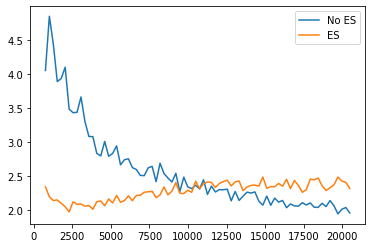

In [6]:
import matplotlib.pyplot as plt
for name, report in reports.items():
    x = [v['Next Training set size'] for v in report]
    y = [v['test_nll'] for v in report]
    plt.plot(x,y, label=name)
plt.legend()
plt.show()